# Detekce anomálií v datech o znečištění ovzduší

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


from lampy import data
from lampy import metrics
from lampy.lstm import LSTM

## Explorace

### Datové zdroje

V [katalogu datové platformy Golemio](https://golemio.cz/cs/node/622) jsou k dispozici dva datové CSV soubory:
jeden za druhé pololetí roku 2018 a druhý za zatím uplynulou část prvního pololetí roku 2019. Data z druhé poloviny obsahují celkem 473529 záznamů z toho jsou ale dostupné odečty PM<sub>10</sub> pouze v 129807 případech. V soubory z roku 2019 je zatím celkem 226672 záznamů a z toho 62518 měření PM<sub>10</sub>.

In [2]:
data_file_2018 = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
data_2018 = pd.read_csv(data_file_2018, index_col='sid', sep=';', parse_dates=['starttimestamp'])
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473529 entries, 24a5mhj5yiqqhmtxzvsztbwxoduhdzyd to y7e4onsytkb3ydonflz5kcbcigkh5ulo
Data columns (total 8 columns):
starttimestamp              473529 non-null datetime64[ns, UTC]
geocoordinates_latitude     473505 non-null float64
geocoordinates_longitude    473505 non-null float64
o3                          407537 non-null float64
pm2p5                       129807 non-null float64
no2                         407537 non-null float64
so2                         407537 non-null float64
pm10                        129807 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 32.5+ MB


In [3]:
data_file_2019 = 'data/2e6bbd16-8d1c-4efa-b0f0-06a74f40d8d3-lampysensory-2019-1pololeti.csv'
data_2019 = pd.read_csv(data_file_2019, index_col='sid', parse_dates=['starttimestamp'])
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226672 entries, 6aivodbkkk3xlwbjlkerclrnk4gtfy3x to oowrrh4zfxs66zdreivyrri2ribhexgc
Data columns (total 8 columns):
starttimestamp              226672 non-null datetime64[ns, UTC]
geocoordinates_latitude     226672 non-null float64
geocoordinates_longitude    226672 non-null float64
o3                          196871 non-null float64
pm2p5                       62518 non-null float64
no2                         196871 non-null float64
so2                         196871 non-null float64
pm10                        62518 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 15.6+ MB


Každý záznam se skládá z následujích atributů:

- `sid` (string): identifikátor stanice;
- `starttimestamp` (datetime): datum a čas měření,
- `o3` (integer with precision): atribut O<sub>3</sub> (ozon, ppb),
- `no2` (integer with precision): atribut NO<sub>2</sub> (oxid dusičitý, ppb),
- `so2` (integer with precision): atribut SO<sub>2</sub> (oxid siřičitý, ppb),
- `pm10` (integer with precision): atribut jemné částice PM<sub>10</sub> (µg m<sup>-3</sup>),
- `pm2p5` (integer with precision): atribut jemné částice PM<sub>2,5</sub> (µg m<sup>-3</sup>),
- `geocoordinates_latitude` (integer with precision): zeměpisná šířka stanice,
- `geocoordinates_longitude` (integer with precision): zeměpisná délka stanice,

kde ppb znamená [parts per bilion](https://en.wikipedia.org/wiki/Parts-per_notation). Datová sada by měla obsahovat odečty z 43 senzorů, které jsou rozmístěny na vybraných lampách, ale ve skutečnosti jsou k dispozici data pouze z 22 senzorů.

In [4]:
sids = data_2018.index.unique()
print('počet senzorů:', len(sids))

počet sensorů: 22


Ze 22 senzorů měří podle dostupných dat polétavý prach PM<sub>10</sub> pouze 6 senzorů z nich nejvíce měření má stanice s identifikátorem: `y7e4onsytkb3ydonflz5kcbcigkh5ulo`.

In [5]:
target = 'pm10'
value_counts = data_2018[target].dropna().index.value_counts()
sid = value_counts.index[0]
value_counts

y7e4onsytkb3ydonflz5kcbcigkh5ulo    32872
heql54pdiq6xb6j74qdpnlovm77jaify    24548
6czebgzn24hwd3vpklvuphomcfcwpqgx    24100
xct4lqv4q3ht3a7peubhfnyyhbsnno7g    17447
bxjhuifodo6nf7bnstd55g3mzw6wfv7c    17078
gdyaoaed7gnarg6kqk2o6bmsjrw6wlk5    13762
Name: sid, dtype: int64

### Trénovací a testovací data

Vezmeme-li si pouze data z této lampy a ponecháme si atributy `o3`, `pm2p5`, `no2`, `so2` a `pm10`, tak dostaneme data dimenze 5, kterí obsahují 32872 záznamů v roce 2018 a 12709 záznamů v roce 2019, a to je dohromady 45581 záznamů za oba roky. Protože pracujeme s časovou řadou jako index zachováme datum a čas měření tedy `starttimestamp`.

Dále se přímo nabízí rozdělit data na trénovací a testovací množinu podle roku měření tj. podle souborů. Takové rozdělení má 72,1% dat v trénovací množině a 27,9% dat v množině testovací.

In [7]:
features = ['o3', 'pm2p5', 'no2', 'so2', 'pm10']

In [8]:
train_data = data_2018.loc[sid].set_index('starttimestamp')[features].sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32872 entries, 2018-07-05 11:52:18+00:00 to 2018-12-31 23:53:11+00:00
Data columns (total 5 columns):
o3       32872 non-null float64
pm2p5    32872 non-null float64
no2      32872 non-null float64
so2      32872 non-null float64
pm10     32872 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


In [9]:
test_data = data_2019.loc[sid].set_index('starttimestamp')[features].sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12709 entries, 2019-01-01 00:03:11+00:00 to 2019-04-04 15:23:07+00:00
Data columns (total 5 columns):
o3       12709 non-null float64
pm2p5    12709 non-null float64
no2      12709 non-null float64
so2      12709 non-null float64
pm10     12709 non-null float64
dtypes: float64(5)
memory usage: 595.7 KB


In [33]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]
n_data = n_train + n_test
print('celkem záznamů:', n_data)
print('trénovacích záznamů: {} ({:.1f}%)'.format(n_train, 100 * n_train / n_data))
print('testovacích záznamů: {} ({:.1f}%)'.format(n_test, 100 * n_test / n_data))

celkem záznamů: 45581
trénovacích záznamů: 32872 (72.1%)
testovacích záznamů: 12709 (27.9%)


### Vizualizace

Základní vizualizace časové řady ukazuje, že v datech o polétavém prachu opravdu nějaké anomálie jsou. Dále je vidět, že data na první pohled neobsahují žádné známky sezóního chování.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f36fe8ffac8>,
      dtype=object)

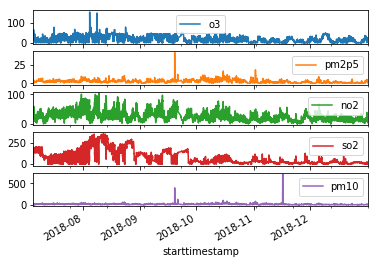

In [11]:
train_data.plot(subplots=True);

Boxplot ukazuje že z hlediska absolutní velikosti hodnoty PM<sub>10</sub> mnoho bodů vybočuje od průměru 14.093698, který má relativně malou standarní odchylku 18.931824. Samozřejmě všechny tyto body nemusí být anomálie, protože naše detekce je časově závislá a záleží na předchozích měřeních.

count    32872.000000
mean        14.093698
std         18.931824
min          1.000000
25%          6.000000
50%         11.430000
75%         18.650000
max        718.900000
Name: pm10, dtype: float64

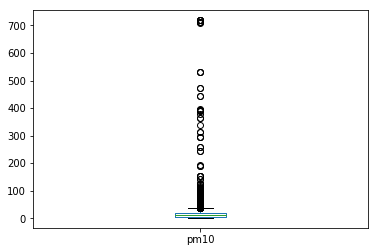

In [50]:
ax = train_data['pm10'].plot.box()
train_data['pm10'].describe()

Jistou lineární závislost naznačuje tak zvaný *lag plot*, který zobrazuje závíslost měření na měřením předchozím, body se totiž shormaždují na diagonále. I zde je vidět zhruba 6 anomálních měření, která leží mimo diagonálu.

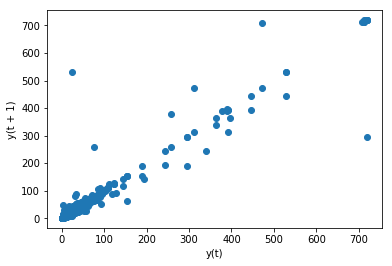

In [40]:
lag_plot(train_data['pm10']);

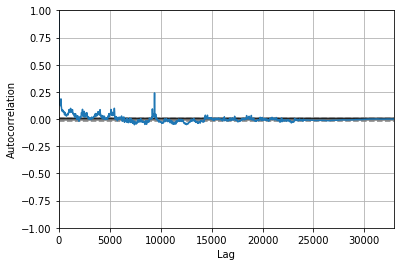

In [14]:
autocorrelation_plot(train_data['pm10']);

Poslední vizualizační pomůckou, kterou prozkoumáváme data je korelační graf. Zajímá nás především korelace příznaku `pm10` s ostaními. Za povšimnutí stojí, že anomálie PM<sub>10</sub> se vyskutují pouze pokud je nízká hladina SO<sub>2</sub> a O<sub>3</sub>.

Každopádně tento vztah zřejmě není lineární, protože korelační koeficient je v obou případech blízký nule (0.028117 resp. -0.067698) v porovnání s největším korelační koeficient, který má s příznakem `pm2p5`, a to 0.530632. Z korelačního grafu PM<sub>10</sub> a PM<sub>2,5</sub> je ale vidět, že nekteré anomáli nastávají jak při zvyšené hladině PM<sub>2,5</sub> tak při jejím normálním stavu.

,o3,pm2p5,no2,so2,pm10
o3,1.000000,-0.056971,-0.034901,0.344683,-0.067698
pm2p5,-0.056971,1.000000,0.501517,0.017095,0.530632
no2,-0.034901,0.501517,1.000000,0.090230,0.320133
so2,0.344683,0.017095,0.090230,1.000000,0.028117
pm10,-0.067698,0.530632,0.320133,0.028117,1.000000


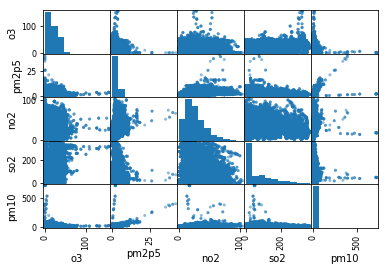

In [15]:
scatter_matrix(train_data)
train_data.corr()

### Rozdíl časů odečtů

Podle specifikace je vyčítací frekvence 15 minut z brány do platformy. Naše data takovéto pravidelné intervaly neobsahují. Průměrně je dostupné nové měření asi každých 7 minut a 52 sekund se standarní odchylkou zhruba 18 minut a 20 sekund.

Zřejmé výpadky ale mohou systém odstavit i na delší dobu. V našich datech je nejdelší prodleva přes 1 den a 15 hodin.

In [16]:
time_delta = pd.Series(train_data.index[1:] - train_data.index[:-1])
time_delta_mean = time_delta.mean()
time_delta_std = time_delta.std()
time_delta_mean, time_delta_std

(Timedelta('0 days 00:07:51.809588'), Timedelta('0 days 00:18:20.667901'))

In [41]:
time_delta.max()

Timedelta('1 days 15:36:51')

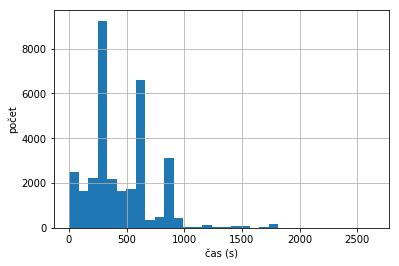

In [45]:
ax = time_delta[time_delta < time_delta_mean + 2 * time_delta_std].dt.total_seconds().hist(bins=32)
ax.set_xlabel('čas (s)')
ax.set_ylabel('počet');

### Log–log plot

Poslední vizualizační pomůckou, která nám pomůže nahlédnou do dat z hlediska jejich absolutní velikosti je tzv. log–log graf. Především v jeho pravé dolní části je vidět, že data obsahují něktré abnormálně velké hodnoty a bude úkolem námi naučených klasifikátorů tyto hodnoty najít i vzhledem k časové závislosti na bodech předchozích.

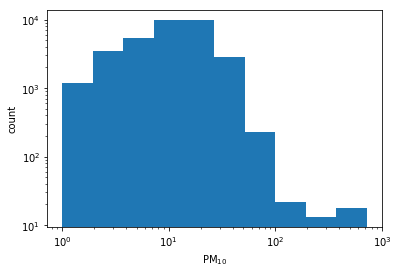

In [47]:
pm10 = train_data['pm10'].values
ax = plt.axes(xlabel='PM$_{10}$', ylabel='count')
bins = np.logspace(np.log10(pm10.min()), np.log10(pm10.max()), num=11)
ax.hist(pm10, bins, log=True)
ax.set_xscale('log')

## Předzpracování

TODO list:

- jak a proč jsem předzpracovávál data?

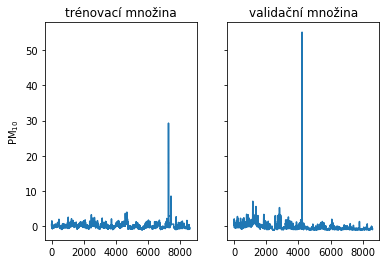

In [51]:
resampled_train_data = data.resample_data(train_data, period='15T')
X, y = data.create_dataset(resampled_train_data)

X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr_all = X_scaler.fit_transform(X_tr_raw)
y_tr = y_scaler.fit_transform(y_tr_raw)

X_val_all = X_scaler.transform(X_val_raw)
y_val = y_scaler.transform(y_val_raw)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('$\mathrm{PM}_{10}$')
ax1.set_title('trénovací množina')
ax2.plot(y_val)
ax2.set_title('validační množina');

## Selekce příznaků

TODO list:

- pomocí LASSO lineární regrese ukázat, že stačí pouze zvolený příznak.

,RMSE,koeficient o3,koeficient pm2p5,koeficient no2,koeficient so2,koeficient pm10
alpha,,,,,,
1.000000e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-07,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-07,0.638710,-0.016697,0.001962,0.019412,0.011029,0.947370
1.000000e-06,0.638710,-0.016697,0.001963,0.019412,0.011028,0.947369


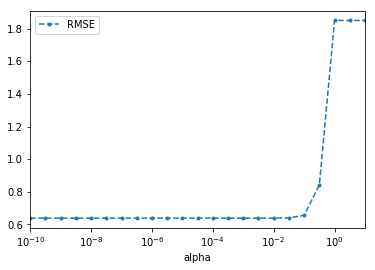

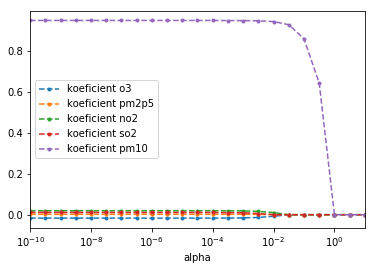

In [21]:
n_features = X_tr_all.shape[1]
columns = ['RMSE'] + ['koeficient ' + feature for feature in features]

n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=columns, dtype=np.float)
lasso_stats.index.name = 'alpha'

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr_all, y_tr)

    y_pred = lasso.predict(X_val_all)
    
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, *lasso.coef_)

lasso_stats.plot(y='RMSE', logx=True, style='.--');
lasso_stats.plot(y=columns[1:], logx=True, style='.--')
lasso_stats

In [22]:
target_index = np.where(train_data.columns == 'pm10')[0][0]
X_tr = X_scaler.fit_transform(X_tr_raw[:, [target_index]])
X_val = X_scaler.transform(X_val_raw[:, [target_index]])

## Porovnání modelů

### Základní model (baseline)

In [23]:
y_pred = X_val
baseline_rmse = metrics.rmse(y_val, y_pred)
print('RMSE základního modelu:', baseline_rmse)

RMSE základního modelu: 0.6492021924513823


### Linearní regrese

In [24]:
linear_predictor = linear_model.LinearRegression()
linear_predictor.fit(X_tr, y_tr)

y_pred = linear_predictor.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('RMSE lineární regrese:', linear_rmse)

RMSE lineární regrese: 0.6401653966120437


,RMSE
okno,
2,0.63797


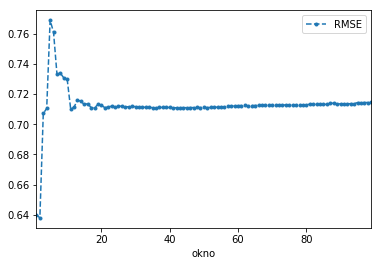

In [25]:
windows = list(range(1, 100))
linear_stats = pd.DataFrame(index=windows, columns=['RMSE'],
                            dtype=np.float)
linear_stats.index.name = 'okno'

for window in windows:
    X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, window)
    X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, window)

    linear = linear_model.LinearRegression()
    linear.fit(X_tr_trans, y_tr_trans)

    y_pred = linear.predict(X_val_trans)
    linear_stats.loc[window] = metrics.rmse(y_val_trans, y_pred)

linear_stats.plot(style='.--')
best_window = linear_stats['RMSE'].idxmin()
best_linear_rmse = linear_stats.loc[best_window, 'RMSE']
linear_stats.loc[[best_window]]

### Long Short-Term Memory (LSTM) rekurentní neuronová síť

epoch: 1 train loss: 0.6347598623343836 validation loss: 2.4457137338962394
epoch: 2 train loss: 0.49585807054664116 validation loss: 2.3054301227367686
epoch: 3 train loss: 0.4202161024406215 validation loss: 2.1974385862784356
epoch: 4 train loss: 0.36220298104693016 validation loss: 2.110852764841574
epoch: 5 train loss: 0.3209536178974793 validation loss: 2.028258200586119
epoch: 6 train loss: 0.2943089032161914 validation loss: 1.949865257950325
epoch: 7 train loss: 0.2732217756014056 validation loss: 1.8913927848624652
epoch: 8 train loss: 0.255934710977399 validation loss: 1.8317886961757195
epoch: 9 train loss: 0.2408657506266117 validation loss: 1.778634272356662
epoch: 10 train loss: 0.22756052906006072 validation loss: 1.7297755447713556
epoch: 11 train loss: 0.21597234892648215 validation loss: 1.6872637933785979
epoch: 12 train loss: 0.207366311013184 validation loss: 1.6841493569376742
epoch: 13 train loss: 0.20538340898979837 validation loss: 1.6020780968909587
epoch: 14

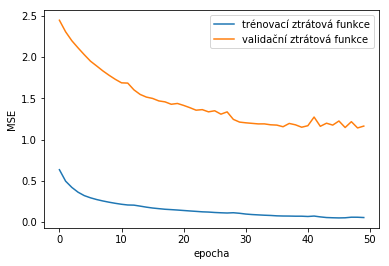

In [26]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr_all, y_tr, X_val_all, y_val,
                        n_epochs=50, seq_len=100)

ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='trénovací ztrátová funkce')
ax.plot(lstm_stats['val_losses'], label='validační ztrátová funkce')
ax.set_xlabel('epocha')
ax.set_ylabel('MSE')
ax.legend()

y_pred = lstm.predict(X_val_all)
lstm_rmse = metrics.rmse(y_val, y_pred)
print('RMSE LSTM:', lstm_rmse)

### Výsledky

In [27]:
print('RMSE základního modelu:', baseline_rmse)
print('RMSE lineární regrese:', linear_rmse)
print('RMSE lineární regrese s oknem:', best_linear_rmse)
print('RMSE LSTM:', lstm_rmse)

RMSE základního modelu: 0.6492021924513823
RMSE lineární regrese: 0.6401653966120437
RMSE lineární regrese s oknem: 0.6379701112790592
RMSE LSTM: 1.0785274088078105


## Detekce anomálií

Detekuju anomálie v datech jak přicházejí bez samplování. Pokud je mezera větší než 15 minut můžu hlásit chybu.

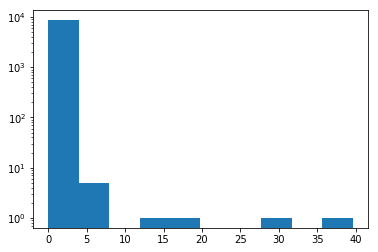

In [28]:
linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_val_trans)
y_delta = np.abs(y_val_trans - y_pred)

ax = plt.axes()
_, bins, _ = ax.hist(y_delta)
ax.set_yscale('log')

threshold = bins[1]

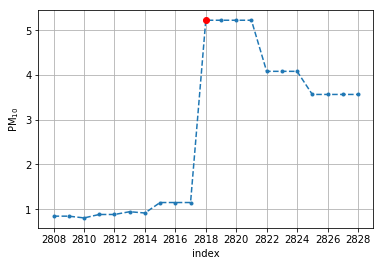

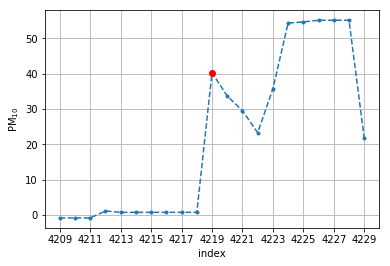

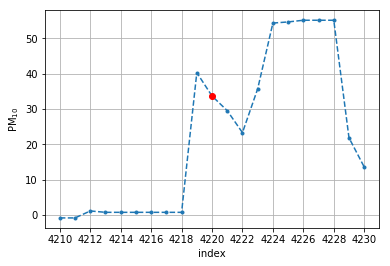

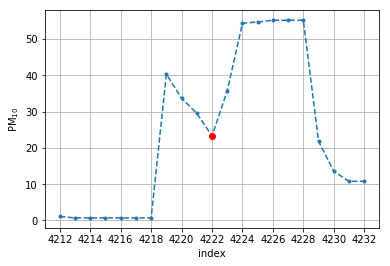

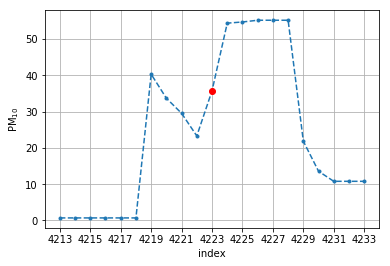

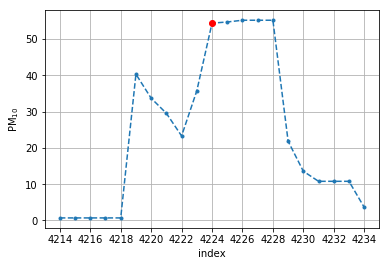

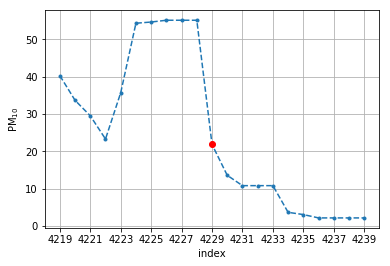

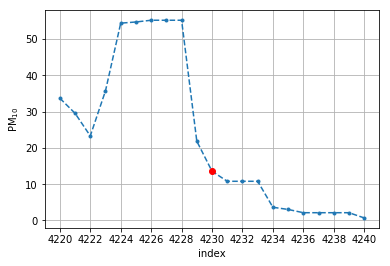

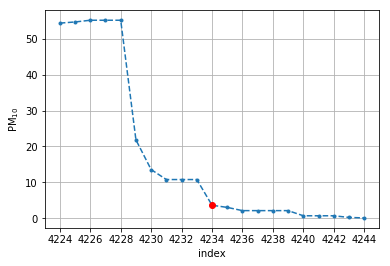

In [29]:
anomalies = y_delta > threshold
window = 10
index = np.arange(anomalies.shape[0])
for anomaly in index[anomalies.ravel()]:
    ax = plt.axes(ylabel='PM$_{10}$', xlabel='index')
    start, end = anomaly - window, anomaly + window + 1
    ax.plot(index[start:end], y_val_trans[start:end], '.--')
    ax.plot(index[anomaly], y_val_trans[anomaly], 'o', color='r')
    ax.set_xticks(index[start:end:2])
    ax.grid()
    plt.show()

## Testování

TODO list:

- testování vybraného modelu na testovacím setu hlavně z hlediska detekovaných anomálií.

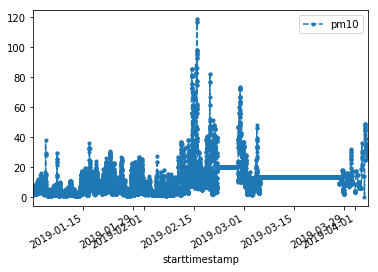

In [30]:
test_data.plot(y='pm10', style='.--')

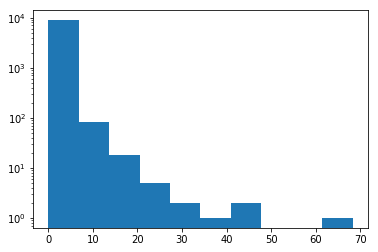

In [31]:
resampled_test_data = data.resample_data(test_data, period='15T')

X_tr = resampled_train_data[['pm10']].values[:-1]
y_tr = resampled_train_data[['pm10']].values[1:]
X_te = resampled_test_data[['pm10']].values[:-1]
y_te = resampled_test_data[['pm10']].values[1:]

linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_te_trans, y_te_trans = data.transform_dataset(X_te, y_te, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_te_trans)
y_delta = np.abs(y_te_trans - y_pred)

ax = plt.axes()
_, bins, _ = ax.hist(y_delta)
ax.set_yscale('log')

threshold = bins[1]

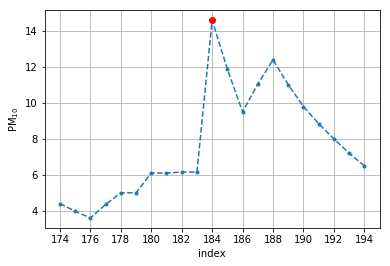

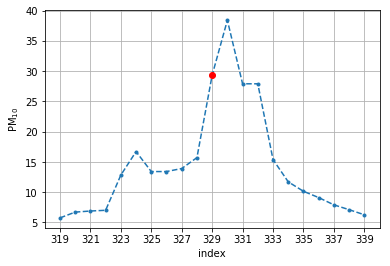

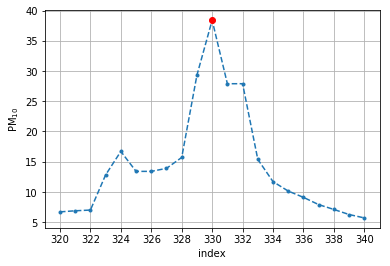

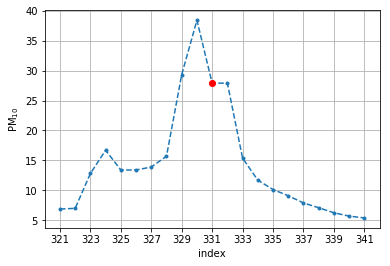

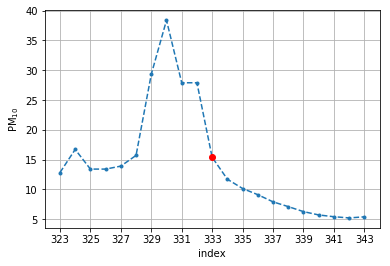

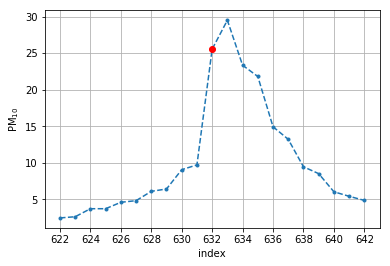

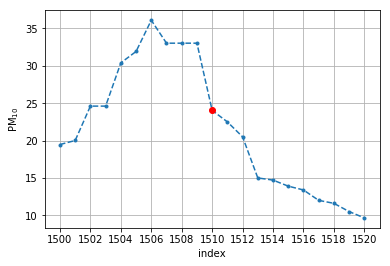

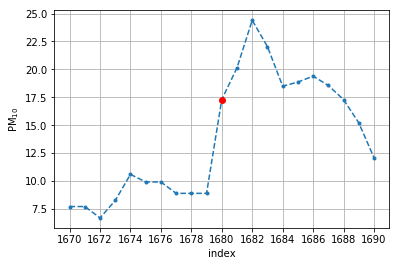

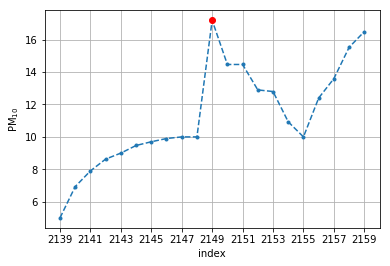

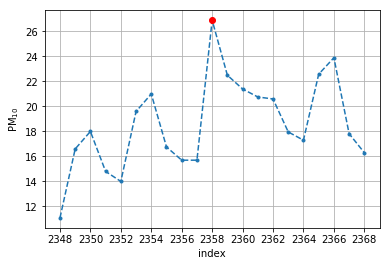

In [32]:
anomalies = y_delta > threshold
window = 10
index = np.arange(anomalies.shape[0])
# show first ten anomalies
for anomaly in index[anomalies.ravel()][:10]:
    ax = plt.axes(ylabel='PM$_{10}$', xlabel='index')
    start, end = anomaly - window, anomaly + window + 1
    ax.plot(index[start:end], y_te_trans[start:end], '.--')
    ax.plot(index[anomaly], y_te_trans[anomaly], 'o', color='r')
    ax.set_xticks(index[start:end:2])
    ax.grid()
    plt.show()

## Závěr